In [1]:
# Imports

import pandas as pd
from pandas import Series,DataFrame
import numpy as np

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Load titanic train and test csv files

In [3]:
X_train = pd.read_csv("./train.csv")
y_train = X_train.pop("Survived")

X_test_orig = pd.read_csv("./test.csv")

In [4]:
data = X_train.append(X_test_orig, ignore_index=True)

In [5]:
data['Title'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Lady              1
Don               1
Jonkheer          1
Mme               1
Capt              1
the Countess      1
Sir               1
Dona              1
Name: Title, dtype: int64

In [6]:
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
data.Title = data.Title.map(normalized_titles)
data.Title.value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

In [7]:
# group by Sex, Pclass, and Title
grouped = data.groupby(['Sex','Pclass', 'Title'])
grouped.Age.median()
data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [8]:
data['CatAge'] = pd.qcut(data.Age, q=5, labels=False )

In [9]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

In [10]:
# try playing with fare data. I saw people adding values to this field online
data["Fare"].fillna(data.Fare.mean(), inplace=True)
embarked = data.Embarked.value_counts().index[0]
data["Embarked"].fillna(embarked, inplace=True)

In [11]:
data = pd.get_dummies(data, columns=['Sex'], prefix = ['Sex'])

In [12]:
# drop columns won't be useful in analysis and prediction
data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','Fare'], axis=1)

In [13]:
data.head()

,Pclass,Age,SibSp,Parch,Embarked,Title,CatAge,Family_Size,Sex_female,Sex_male
0,3,22.0,1,0,S,Mr,1,2,0,1
1,1,38.0,1,0,C,Mrs,3,2,1,0
2,3,26.0,0,0,S,Miss,1,1,1,0
3,1,35.0,1,0,S,Mrs,3,2,1,0
4,3,35.0,0,0,S,Mr,3,1,0,1


In [14]:
numeric_variables = list(data.dtypes[data.dtypes != "object"].index)
data = data[numeric_variables]

In [15]:
data.isnull().sum()

Pclass         0
Age            0
SibSp          0
Parch          0
CatAge         0
Family_Size    0
Sex_female     0
Sex_male       0
dtype: int64

In [16]:
X_train = data.iloc[:891]
X_test = data.iloc[891:]

### Modeling

In [17]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

In [18]:
svc_params = [
   { 'C': [0.001, 0.01, 0.1, 1, 5, 10], 
     'gamma' : [0.001, 0.01, 0.1],
   },
]

In [19]:
from sklearn.svm import LinearSVC

svc_clf_1 = LinearSVC()
svc_clf_1.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="accuracy")

array([0.78787879, 0.82491582, 0.78787879])

In [21]:
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="precision")

array([0.72173913, 0.76724138, 0.78021978])

In [22]:
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="recall")

array([0.72807018, 0.78070175, 0.62280702])

Plot the learning curve. The Score refers to R<sup>2</sup>  score. 

<module 'matplotlib.pyplot' from 'C:\\Users\\ndbie\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

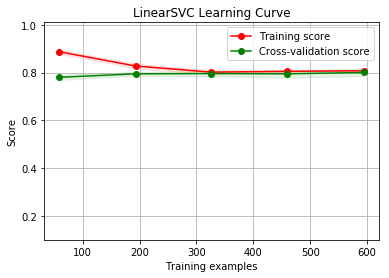

In [23]:
plot_learning_curve(svc_clf_1, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.01), cv=3)    

In [24]:
svc_clf_2 = SVC()
svc_clf_2.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<module 'matplotlib.pyplot' from 'C:\\Users\\ndbie\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

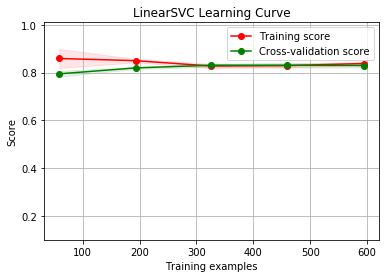

In [25]:
plot_learning_curve(svc_clf_2, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.01), cv=3)    

In [26]:
svc_clf_3 = SVC(kernel='poly',degree=2)
svc_clf_3.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<module 'matplotlib.pyplot' from 'C:\\Users\\ndbie\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

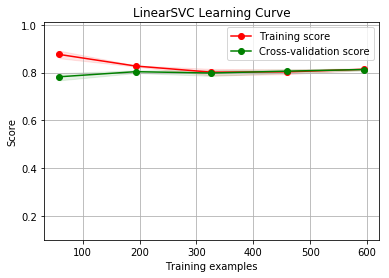

In [27]:
plot_learning_curve(svc_clf_3, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.01), cv=3)    

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
forrest_params = dict(
   max_depth = [n for n in range(9, 14)],
   min_samples_split = [n for n in range(4, 11)],
   min_samples_leaf = [n for n in range(2, 5)],
   n_estimators = [n for n in range(10, 60, 10)],
)
rf = RandomForestClassifier(forrest_params)
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)

gs = gs.fit(X_train, y_train)

In [29]:
SVC_test = GridSearchCV(svc_clf_2, svc_params, cv=3)
SVC_test.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 5, 10], 'gamma': [0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
print("Best score: {}".format(gs.best_score_))
print("Optimal params: {}".format(gs.best_estimator_))

Best score: 0.8305274971941639
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [34]:
y_pred = gs.predict(X_test)

In [35]:
submission = pd.DataFrame({
        "PassengerId": X_test_orig["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('titanic.csv', index=False)